In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import spacy
import pathlib
from collections import namedtuple

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
data_path = pathlib.Path("data/raw")
output_path = pathlib.Path("data/processed")
DocPair = namedtuple('DocPair', ['infile','outfile'])

In [5]:
doclist = [
    DocPair(outfile="us-eo-lines.txt", 
            infile="US Executive Order on the Safe, Secure, and Trustworthy Development and Use of Artificial Intelligence.md"),
    DocPair(outfile="tbs-automated-decisions.txt",
            infile="TBS Directive on Automated Decision-Making.md"),
    DocPair(outfile="g7-coc.txt",
            infile="G7 Hiroshima Process International Code of Conduct for Organizations Developing Advanced AI Systems.md"),
    DocPair(outfile="bletchley-declaration.txt",
            infile="UK The Bletchley Declaration by Countries Attending the AI Safety Summit, 1-2 November 2023.md"),
]

In [6]:
# Load the spaCy model with the statistical sentencizer
nlp_sentencizer = spacy.lang.en.English()
# Add the sentencizer component explicitly (if not already added)
if "sentencizer" not in nlp_sentencizer.pipe_names:
    nlp_sentencizer.create_pipe("sentencizer")
    nlp_sentencizer.add_pipe("sentencizer")

# Load the full spaCy English model
nlp_full_model = spacy.load("en_core_web_sm")



In [7]:
for docs in doclist:
    input_file = data_path / docs.infile
    output_file = output_path / docs.outfile
    
    # Read the text from the file
    with open(input_file, 'r', encoding='utf-8') as file:
        text = file.read()
    print(f"Splitting {docs.infile} -> {docs.outfile}")

    # Tokenize using the statistical sentencizer
    doc_sentencizer = nlp_sentencizer(text)
    sentences_sentencizer = [sent.text for sent in doc_sentencizer.sents]
    # Tokenize using the full spaCy English model
    #doc_full_model = nlp_full_model(text)
    #sentences_full_model = [sent.text for sent in doc_full_model.sents]
    
    with open (output_file, "w") as fw:
        for sentence in sentences_sentencizer:
            if sentence.rstrip():
                fw.write(sentence) 
    

Splitting US Executive Order on the Safe, Secure, and Trustworthy Development and Use of Artificial Intelligence.md -> us-eo-lines.txt
Splitting TBS Directive on Automated Decision-Making.md -> tbs-automated-decisions.txt
Splitting G7 Hiroshima Process International Code of Conduct for Organizations Developing Advanced AI Systems.md -> g7-coc.txt
Splitting UK The Bletchley Declaration by Countries Attending the AI Safety Summit, 1-2 November 2023.md -> bletchley-declaration.txt


In [8]:
import llm

embedding_model = llm.get_embedding_model("lv2")

In [9]:
text_to_embed = [f"passage: {text.strip()}" for file in [output_path / docs.outfile for docs in doclist] for text in open(file) if len(text.strip()) > 4]
all_embeddings = list(embedding_model.embed_multi(text_to_embed))

In [10]:
import numpy as np

In [11]:
np.save("data/processed/all_sentence_embeddings.npy", np.array(all_embeddings))

In [12]:
which_document_labels = [f"{file.name}" for file in [output_path / docs.outfile for docs in doclist] for text in open(file) if len(text.strip()) > 4]

In [13]:
np.save("data/processed/all_sentence_labels.npy", np.array(which_document_labels))

In [14]:
np.save("data/processed/text_for_embedding.npy", np.array(text_to_embed))

In [15]:
import umap

In [16]:
mapper = umap.UMAP(metric="cosine", min_dist=0.25, random_state=42).fit(np.asarray(all_embeddings))

/local/home/lmmcinn/anaconda3/envs/llm_ai_eo/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [17]:
import umap.plot
import pandas as pd

/local/home/lmmcinn/anaconda3/envs/llm_ai_eo/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


<Axes: >

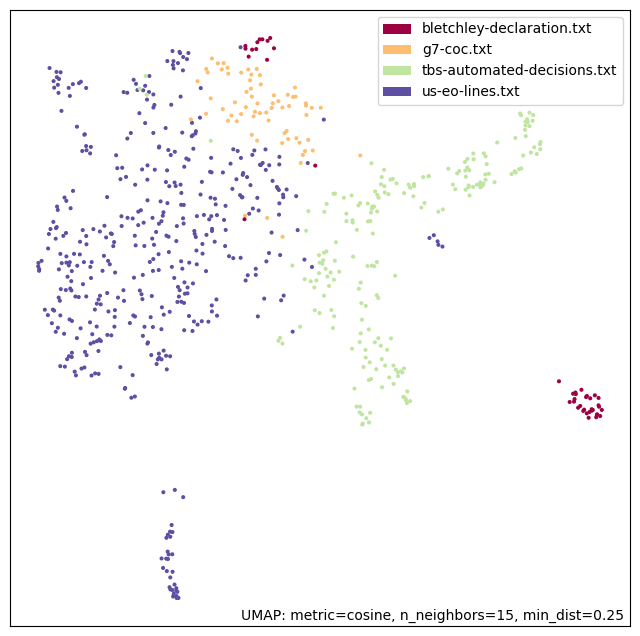

In [18]:
umap.plot.points(mapper, labels=np.asarray(which_document_labels))

In [20]:
umap.plot.output_notebook()

Loading BokehJS ...

In [21]:
p = umap.plot.interactive(mapper, labels=np.asarray(which_document_labels), hover_data=pd.DataFrame({"text":text_to_embed}), point_size=5)
umap.plot.show(p)

In [22]:
import thisnotthat as tnt
import panel as pn
import pandas as pd
import textwrap

In [23]:
pn.extension()

In [24]:
marker_sizes = [0.005 * np.sqrt(len(x.strip("passage: "))) for x in text_to_embed]
labels = pd.Series(which_document_labels).map(
    {
        "us-eo-lines.txt": "US Executive Order on AI",
        "tbs-automated-decisions.txt": "TBS Directive of Automated Decision Making",
        "g7-coc.txt": "G7 Hiroshima Process Code of Conduct",
        "bletchley-declaration.txt": "AI Safety Summit Bletchley Declaration",
    }
)
hover_text = [textwrap.fill(x.strip("passage: "), 32) for x in text_to_embed]

In [25]:
plot_pane = tnt.BokehPlotPane(
    mapper.embedding_,
    labels = labels,
    marker_size=marker_sizes,
    legend_location="bottom_right",
    hover_text=hover_text,
    max_point_size=0.006,
    min_point_size=0.002,
    sizing_mode="stretch_width",
    tooltip_template="""<div style="width:300px">@hover_text</div><p>""",
)
text_search = tnt.SimpleSearchWidget(plot_pane, raw_dataframe=pd.DataFrame({"text": hover_text}))

In [26]:
app = pn.Column(text_search, plot_pane)
app

Column
    [0] WidgetBox(horizontal=True, name='Search', sizing_mode='stretch_width')
        [0] Markdown(str, align=('end', 'center'))
        [1] TextInput(align=('start', 'center'), placeholder='Enter search string ...', sizing_mode='stretch_width')
    [1] BokehPlotPane(color_by_palette=['#1f77b4', '#ff7f0e', ...], color_by_vector=Series([], dtype: object), label_color_factors=['AI Safety Summit Bletchl...], label_color_palette=['#1f77b4', '#ff7f0e', ...], labels=0                    US Ex..., name='Plot')

In [27]:
from bokeh.resources import INLINE
app.save('ai_llm_embedding_demo.html', resources=INLINE)